<a href="https://colab.research.google.com/github/BcCrypto/examples/blob/master/Linear_Model_with_Estimators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.feature_column as fc

import os
import sys

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
tf.enable_eager_execution()

In [3]:
! pip install -q requests
! git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3217, done.
remote: Counting objects: 100% (3217/3217), done.
remote: Compressing objects: 100% (2741/2741), done.
remote: Total 3217 (delta 582), reused 2040 (delta 399), pack-reused 0
Receiving objects: 100% (3217/3217), 370.67 MiB | 36.80 MiB/s, done.
Resolving deltas: 100% (582/582), done.
Checking out files: 100% (3048/3048), done.


In [0]:
models_path = os.path.join(os.getcwd(), 'models')

sys.path.append(models_path)

In [0]:
from official.wide_deep import census_dataset
from official.wide_deep import census_main

census_dataset.download("/tmp/census_data/")

In [0]:
#export PYTHONPATH=${PYTHONPATH}:"$(pwd)/models"
#running from python you need to set the `os.environ` or the subprocess will not see the directory.

if "PYTHONPATH" in os.environ:
  os.environ['PYTHONPATH'] += os.pathsep +  models_path
else:
  os.environ['PYTHONPATH'] = models_path

In [12]:
!python -m official.wide_deep.census_main --help

W0728 21:57:18.465893 140362002524032 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_main.py:114: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0728 21:57:18.466246 140362002524032 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_main.py:114: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

Train DNN on census income dataset.
flags:

/content/models/official/wide_deep/census_main.py:
  -bs,--batch_size:
    Batch size for training and evaluation. When using multiple gpus, this is
    the
    global batch size for all devices. For example, if the batch size is 32 and
    there are 4 GPUs, each GPU will get 8 examples on each step.
    (default: '40')
    (an integer)
  --[no]clean:
    If set, model_dir will be removed if it exists.
    (default: 'false')
  -dd,--data_dir:
    The location of the input data.
    (default: '/tmp/census_da

In [13]:
!python -m official.wide_deep.census_main --model_type=wide --train_epochs=2

W0728 21:58:08.412087 140239895005056 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_main.py:114: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0728 21:58:08.412444 140239895005056 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_main.py:114: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.

W0728 21:58:08.415704 140239895005056 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_dataset.py:78: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0728 21:58:08.415970 140239895005056 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_dataset.py:81: The name tf.gfile.Exists is deprecated. Please use tf.io.gfile.exists instead.

W0728 21:58:08.417126 140239895005056 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_main.py:49: The name tf

In [14]:
!ls  /tmp/census_data/

adult.data  adult.test


In [0]:
train_file = "/tmp/census_data/adult.data"
test_file = "/tmp/census_data/adult.test"

In [16]:
import pandas

train_df = pandas.read_csv(train_file, header = None, names = census_dataset._CSV_COLUMNS)
test_df = pandas.read_csv(test_file, header = None, names = census_dataset._CSV_COLUMNS)

train_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [0]:
def easy_input_function(df, label_key, num_epochs, shuffle, batch_size):
  label = df[label_key]
  ds = tf.data.Dataset.from_tensor_slices((dict(df),label))

  if shuffle:
    ds = ds.shuffle(10000)

  ds = ds.batch(batch_size).repeat(num_epochs)

  return ds

In [18]:
ds = easy_input_function(train_df, label_key='income_bracket', num_epochs=5, shuffle=True, batch_size=10)

for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys())[:5])
  print()
  print('A batch of Ages  :', feature_batch['age'])
  print()
  print('A batch of Labels:', label_batch )

Some feature keys: ['age', 'workclass', 'fnlwgt', 'education', 'education_num']

A batch of Ages  : tf.Tensor([66 18 57 44 33 43 26 68 44 37], shape=(10,), dtype=int32)

A batch of Labels: tf.Tensor(
[b'>50K' b'<=50K' b'<=50K' b'<=50K' b'>50K' b'<=50K' b'<=50K' b'>50K'
 b'<=50K' b'>50K'], shape=(10,), dtype=string)


In [19]:
import inspect
print(inspect.getsource(census_dataset.input_fn))

def input_fn(data_file, num_epochs, shuffle, batch_size):
  """Generate an input function for the Estimator."""
  assert tf.gfile.Exists(data_file), (
      '%s not found. Please make sure you have run census_dataset.py and '
      'set the --data_dir argument to the correct path.' % data_file)

  def parse_csv(value):
    tf.logging.info('Parsing {}'.format(data_file))
    columns = tf.decode_csv(value, record_defaults=_CSV_COLUMN_DEFAULTS)
    features = dict(zip(_CSV_COLUMNS, columns))
    labels = features.pop('income_bracket')
    classes = tf.equal(labels, '>50K')  # binary classification
    return features, classes

  # Extract lines from input files using the Dataset API.
  dataset = tf.data.TextLineDataset(data_file)

  if shuffle:
    dataset = dataset.shuffle(buffer_size=_NUM_EXAMPLES['train'])

  dataset = dataset.map(parse_csv, num_parallel_calls=5)

  # We call repeat after shuffling, rather than before, to prevent separate
  # epochs from blending together.
  dataset = 

In [20]:
ds = census_dataset.input_fn(train_file, num_epochs=5, shuffle=True, batch_size=10)

for feature_batch, label_batch in ds.take(1):
  print('Feature keys:', list(feature_batch.keys())[:5])
  print()
  print('Age batch   :', feature_batch['age'])
  print()
  print('Label batch :', label_batch )

W0728 22:01:29.523567 139660764972928 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_dataset.py:167: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

W0728 22:01:29.525223 139660764972928 deprecation_wrapper.py:119] From /content/models/official/wide_deep/census_dataset.py:168: The name tf.decode_csv is deprecated. Please use tf.io.decode_csv instead.



Feature keys: ['age', 'workclass', 'fnlwgt', 'education', 'education_num']

Age batch   : tf.Tensor([44 35 47 23 34 23 38 23 19 61], shape=(10,), dtype=int32)

Label batch : tf.Tensor([False False False False False False False False False False], shape=(10,), dtype=bool)


In [0]:
import functools

train_inpf = functools.partial(census_dataset.input_fn, train_file, num_epochs=2, shuffle=True, batch_size=64)
test_inpf = functools.partial(census_dataset.input_fn, test_file, num_epochs=1, shuffle=False, batch_size=64)

In [0]:
age = fc.numeric_column('age')

In [24]:
fc.input_layer(feature_batch, [age]).numpy()

W0728 22:02:28.578174 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:205: NumericColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0728 22:02:28.580301 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:2115: NumericColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0728 22:02:28.582317 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_c

array([[44.],
       [35.],
       [47.],
       [23.],
       [34.],
       [23.],
       [38.],
       [23.],
       [19.],
       [61.]], dtype=float32)

In [25]:
classifier = tf.estimator.LinearClassifier(feature_columns=[age])
classifier.train(train_inpf)
result = classifier.evaluate(test_inpf)

clear_output()  # used for display in notebook
print(result)

{'accuracy': 0.76334375, 'accuracy_baseline': 0.76377374, 'auc': 0.67818236, 'auc_precision_recall': 0.31133777, 'average_loss': 0.5249432, 'label/mean': 0.23622628, 'loss': 33.516075, 'precision': 0.31578946, 'prediction/mean': 0.21833685, 'recall': 0.0015600624, 'global_step': 1018}


In [26]:
education_num = tf.feature_column.numeric_column('education_num')
capital_gain = tf.feature_column.numeric_column('capital_gain')
capital_loss = tf.feature_column.numeric_column('capital_loss')
hours_per_week = tf.feature_column.numeric_column('hours_per_week')

my_numeric_columns = [age,education_num, capital_gain, capital_loss, hours_per_week]

fc.input_layer(feature_batch, my_numeric_columns).numpy()

array([[44.,  0.,  0.,  9., 37.],
       [35.,  0.,  0., 12., 50.],
       [47.,  0.,  0.,  9., 37.],
       [23.,  0.,  0., 10., 25.],
       [34.,  0.,  0.,  9., 40.],
       [23.,  0.,  0.,  9., 25.],
       [38.,  0.,  0.,  9., 48.],
       [23.,  0.,  0.,  9., 35.],
       [19.,  0.,  0., 10., 20.],
       [61.,  0.,  0.,  4., 40.]], dtype=float32)

In [27]:
classifier = tf.estimator.LinearClassifier(feature_columns=my_numeric_columns)
classifier.train(train_inpf)

result = classifier.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %s' % (key, value))

accuracy: 0.76377374
accuracy_baseline: 0.76377374
auc: 0.49290448
auc_precision_recall: 0.28927487
average_loss: 0.68115866
global_step: 1018
label/mean: 0.23622628
loss: 43.48998
precision: 0.0
prediction/mean: 0.14744724
recall: 0.0


In [0]:
relationship = fc.categorical_column_with_vocabulary_list(
    'relationship',
    ['Husband', 'Not-in-family', 'Wife', 'Own-child', 'Unmarried', 'Other-relative'])

In [30]:
fc.input_layer(feature_batch, [age, fc.indicator_column(relationship)])

W0728 22:03:44.517793 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:205: IndicatorColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0728 22:03:44.521424 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:2115: IndicatorColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0728 22:03:44.523721 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/featu

<tf.Tensor: id=5099, shape=(10, 7), dtype=float32, numpy=
array([[44.,  0.,  1.,  0.,  0.,  0.,  0.],
       [35.,  0.,  0.,  0.,  0.,  1.,  0.],
       [47.,  0.,  0.,  0.,  0.,  1.,  0.],
       [23.,  0.,  0.,  0.,  1.,  0.,  0.],
       [34.,  0.,  1.,  0.,  0.,  0.,  0.],
       [23.,  0.,  0.,  0.,  1.,  0.,  0.],
       [38.,  1.,  0.,  0.,  0.,  0.,  0.],
       [23.,  0.,  0.,  0.,  0.,  1.,  0.],
       [19.,  0.,  0.,  0.,  1.,  0.,  0.],
       [61.,  0.,  0.,  0.,  0.,  1.,  0.]], dtype=float32)>

In [0]:
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    'occupation', hash_bucket_size=1000)

In [32]:
for item in feature_batch['occupation'].numpy():
    print(item.decode())

Other-service
Other-service
Exec-managerial
Machine-op-inspct
Adm-clerical
Handlers-cleaners
Machine-op-inspct
Other-service
Craft-repair
Other-service


In [33]:
occupation_result = fc.input_layer(feature_batch, [fc.indicator_column(occupation)])

occupation_result.numpy().shape

W0728 22:04:14.995528 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:4236: HashedCategoricalColumn._get_sparse_tensors (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0728 22:04:14.998199 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:2115: HashedCategoricalColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0728 22:04:15.000690 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/pytho

(10, 1000)

In [34]:
tf.argmax(occupation_result, axis=1).numpy()

array([527, 527, 800, 911,  96,  10, 911, 527, 466, 527])

In [0]:
education = tf.feature_column.categorical_column_with_vocabulary_list(
    'education', [
        'Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
        '5th-6th', '10th', '1st-4th', 'Preschool', '12th'])

marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    'marital_status', [
        'Married-civ-spouse', 'Divorced', 'Married-spouse-absent',
        'Never-married', 'Separated', 'Married-AF-spouse', 'Widowed'])

workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    'workclass', [
        'Self-emp-not-inc', 'Private', 'State-gov', 'Federal-gov',
        'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'])


my_categorical_columns = [relationship, occupation, education, marital_status, workclass]

In [36]:
classifier = tf.estimator.LinearClassifier(feature_columns=my_numeric_columns+my_categorical_columns)
classifier.train(train_inpf)
result = classifier.evaluate(test_inpf)

clear_output()

for key,value in sorted(result.items()):
  print('%s: %s' % (key, value))

accuracy: 0.8240894
accuracy_baseline: 0.76377374
auc: 0.8670283
auc_precision_recall: 0.652477
average_loss: 0.5918715
global_step: 1018
label/mean: 0.23622628
loss: 37.789253
precision: 0.63156486
prediction/mean: 0.2587861
recall: 0.6128445


In [0]:
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In [38]:
fc.input_layer(feature_batch, [age, age_buckets]).numpy()

W0728 22:05:15.130406 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:205: BucketizedColumn._get_dense_tensor (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0728 22:05:15.131662 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column.py:2115: BucketizedColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0728 22:05:15.134578 139660764972928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/fea

array([[44.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [35.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [47.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [23.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [34.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [23.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [38.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [23.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [19.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [61.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]],
      dtype=float32)

In [0]:
education_x_occupation = tf.feature_column.crossed_column(
    ['education', 'occupation'], hash_bucket_size=1000)

In [0]:
age_buckets_x_education_x_occupation = tf.feature_column.crossed_column(
    [age_buckets, 'education', 'occupation'], hash_bucket_size=1000)

In [0]:
import tempfile

base_columns = [
    education, marital_status, relationship, workclass, occupation,
    age_buckets,
]

crossed_columns = [
    tf.feature_column.crossed_column(
        ['education', 'occupation'], hash_bucket_size=1000),
    tf.feature_column.crossed_column(
        [age_buckets, 'education', 'occupation'], hash_bucket_size=1000),
]

model = tf.estimator.LinearClassifier(
    model_dir=tempfile.mkdtemp(),
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(learning_rate=0.1))

In [0]:
train_inpf = functools.partial(census_dataset.input_fn, train_file,
                               num_epochs=40, shuffle=True, batch_size=64)

model.train(train_inpf)

clear_output()  # used for notebook display

In [44]:
results = model.evaluate(test_inpf)

clear_output()

for key,value in sorted(results.items()):
  print('%s: %0.2f' % (key, value))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.64
precision: 0.69
prediction/mean: 0.24
recall: 0.56


In [45]:
import numpy as np

predict_df = test_df[:20].copy()

pred_iter = model.predict(
    lambda:easy_input_function(predict_df, label_key='income_bracket',
                               num_epochs=1, shuffle=False, batch_size=10))

classes = np.array(['<=50K', '>50K'])
pred_class_id = []

for pred_dict in pred_iter:
  pred_class_id.append(pred_dict['class_ids'])

predict_df['predicted_class'] = classes[np.array(pred_class_id)]
predict_df['correct'] = predict_df['predicted_class'] == predict_df['income_bracket']

clear_output()

predict_df[['income_bracket','predicted_class', 'correct']]

,income_bracket,predicted_class,correct
0,<=50K,<=50K,True
1,<=50K,<=50K,True
2,>50K,<=50K,False
3,>50K,<=50K,False
4,<=50K,<=50K,True
5,<=50K,<=50K,True
6,<=50K,<=50K,True
7,>50K,>50K,True
8,<=50K,<=50K,True
9,<=50K,<=50K,True


In [46]:
model_l1 = tf.estimator.LinearClassifier(
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=10.0,
        l2_regularization_strength=0.0))

model_l1.train(train_inpf)

results = model_l1.evaluate(test_inpf)
clear_output()
for key in sorted(results):
  print('%s: %0.2f' % (key, results[key]))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.47
precision: 0.69
prediction/mean: 0.24
recall: 0.55


In [53]:
model_l2 = tf.estimator.LinearClassifier(
    feature_columns=base_columns + crossed_columns,
    optimizer=tf.train.FtrlOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=0.0,
        l2_regularization_strength=10.0))

model_l2.train(train_inpf)

results = model_l2.evaluate(test_inpf)
clear_output()
for key in sorted(results):
  print('%s: %0.2f' % (key, results[key]))

accuracy: 0.84
accuracy_baseline: 0.76
auc: 0.88
auc_precision_recall: 0.69
average_loss: 0.35
global_step: 20351.00
label/mean: 0.24
loss: 22.46
precision: 0.69
prediction/mean: 0.24
recall: 0.56


In [0]:
def get_flat_weights(model):
  weight_names = [
      name for name in model.get_variable_names()
      if "linear_model" in name and "Ftrl" not in name]

  weight_values = [model.get_variable_value(name) for name in weight_names]

  weights_flat = np.concatenate([item.flatten() for item in weight_values], axis=0)

  return weights_flat

weights_flat = get_flat_weights(model)
weights_flat_l1 = get_flat_weights(model_l1)
weights_flat_l2 = get_flat_weights(model_l2)

In [0]:
weight_mask = weights_flat != 0

weights_base = weights_flat[weight_mask]
weights_l1 = weights_flat_l1[weight_mask]
weights_l2 = weights_flat_l2[weight_mask]

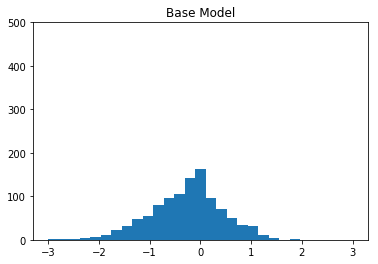

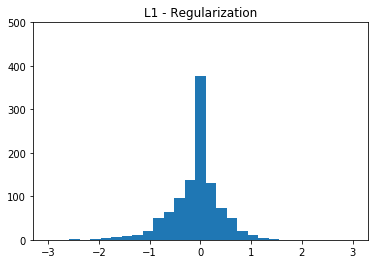

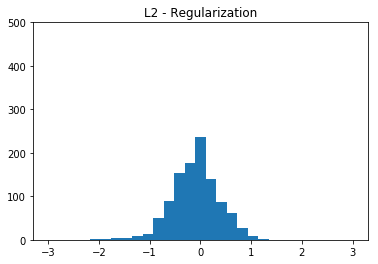

In [56]:
plt.figure()
_ = plt.hist(weights_base, bins=np.linspace(-3,3,30))
plt.title('Base Model')
plt.ylim([0,500])

plt.figure()
_ = plt.hist(weights_l1, bins=np.linspace(-3,3,30))
plt.title('L1 - Regularization')
plt.ylim([0,500])

plt.figure()
_ = plt.hist(weights_l2, bins=np.linspace(-3,3,30))
plt.title('L2 - Regularization')
_=plt.ylim([0,500])
